In [1]:
import os
import time

import umap
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import multiMACA as maca

import warnings
warnings.filterwarnings("ignore")

In [2]:
##Use PanglaoDB as marker database
##PanglaoDB available at https://panglaodb.se/index.html
pg_df = pd.read_table("MACA/PanglaoDB_markers_27_Mar_2020.tsv")

##human lung atlas markers
markers_xls = pd.ExcelFile('Downloads/Atlas_markers/Lung/41586_2020_2922_MOESM6_ESM.xlsx')

cell_markers={}

##human kidney atlas markers
markers_dir = "Downloads/Atlas_markers/Kidney/"
files = os.listdir(markers_dir)

for f in files:
    markers = pd.read_csv(markers_dir+f,index_col=0, header=1)
    logFold = np.log((markers['geneExpression'].values+1)/(markers['geneExpressionOutsideCluster'].values+1))
    markers = markers[logFold>=1]
    markers = markers[markers['geneFrequency'].values>=0.8]
    markers = markers[markers['geneFrequencyOutsideCluster'].values<0.5]
    celltypes = markers['Cell.type'].values.tolist()
    celltypes = list(set(celltypes))
    for c in celltypes:
        sub_markers = markers[markers['Cell.type'].values==c]
        m = sub_markers['Gene'].values.tolist()
        if len(m)>=5 and len(m)<=300:
            cell_markers[c]=m

for cluster in markers_xls.sheet_names:
    if 'SS2' not in cluster and 'SS' not in cluster:
        markers = pd.read_excel(markers_xls, cluster,header=None,index_col=False)
        celltype = markers.iloc[0,0]
        markers = pd.read_excel(markers_xls, cluster,header=1,index_col=0)
        markers = markers[markers['avg_logFC'].values>=1]
        markers = markers[markers['pct_in_cluster'].values>=0.8]
        markers = markers[markers['pct_out_cluster'].values<0.5]
        markers = markers.index.tolist()
        if len(markers)>=5 and len(markers)<=300:
            cell_markers[celltype]=markers
            
##remove mouse specific genes
pg_df = pg_df[pg_df['species']!='Mm']
#cell_markers = {}##cell_marker is dictionary that contains names of cell types and their marker genes
for i in list(set(pg_df["cell type"].values.tolist())):
    genes = pg_df[pg_df["cell type"]==i]['official gene symbol'].values.tolist()
    ##only use cell type with at least 5 genes and less than 300 genes
    if len(genes)>=5 and len(genes)<=300:
        cell_markers[i]=genes

In [3]:
data = "Downloads/MACA_COVID/BALF_VIB-UGent_processed_cleaned.h5ad"
adata = sc.read_h5ad(data)
marker_list = []
for k, v in cell_markers.items():
    marker_list += v
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in adata.var.index]
len(marker_list)
adata = adata[adata.obs['Annotation'].values!='Doublet']
adata = adata[:,marker_list]

In [3]:
data = "Downloads/MACA_COVID/immunodeficiency_PMBCs.h5ad"
adata = sc.read_h5ad(data)
marker_list = []
for k, v in cell_markers.items():
    marker_list += v
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in adata.var.index]
len(marker_list)
adata = adata[:,marker_list]

In [4]:
##run MACA
start_time = time.time()

##step 1 expression to cell type score
scores, labels = maca.gene2cell(ad=adata,cell_markers=cell_markers)

##step 2 clustering
label_list = maca.parallel(scores=scores,labels=labels)

##step 3 ensemble
annotation = maca.ensemble_labels(label_list)
annotation = np.array(annotation)

print("--- %s mins ---" % int((time.time() - start_time)/60))

(240627, 225)
--- 13 mins ---


Trying to set attribute `.obs` of view, copying.
... storing 'Annotation' as categorical


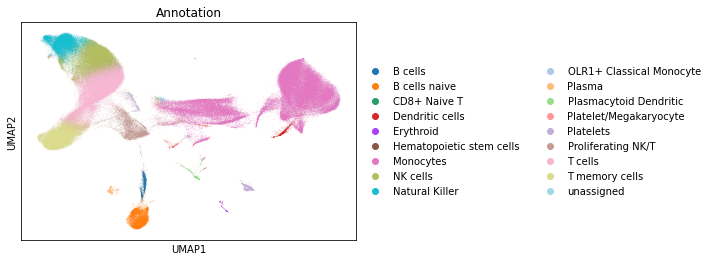

In [5]:
##visualization
adata.obs['Annotation']=annotation
embedding = umap.UMAP(n_neighbors=15,min_dist=0.2,n_components=2,
                      metric='cosine').fit_transform(scores.values)
embedding = pd.DataFrame(embedding)
embedding.columns=['UMAP1','UMAP2']
adata.obsm['X_umap'] = embedding.iloc[:,:2].values

sc.pl.umap(adata, color=["Annotation"])